In [1]:
import torch

In [2]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

In [ ]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5

    def forward(self, x:torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_o = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x:torch.Tensor):
        batch, seq_len, dim = x.shape
        queries = self.W_q(x).view(batch, seq_len, self.num_heads, self.head_dim)
        keys = self.W_k(x).view(batch, seq_len, self.num_heads, self.head_dim)
        values = self.W_v(x).view(batch, seq_len, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)  # (B, num_heads, L, head_dim)
        keys = keys.transpose(1, 2)        # (B, num_heads, L, head_dim)
        values = values.transpose(1, 2)    # (B, num_heads, L, head_dim)

        attn_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5 # （B, num_heads, L, L）
        attn_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values  # (B, num_heads, L, head_dim)
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch, seq_len, dim)  # (B, L, D)
        return self.W_o(context_vec)
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, 4 * emb_dim)
        self.fc2 = nn.Linear(4 * emb_dim, emb_dim)
        # self.act = nn.GELU()
        self.act = GELU()

    def forward(self, x:torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['n_heads'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ffn = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x:torch.Tensor):
        # 多头
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut
        # 前馈层
        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + shortcut

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emp = nn.Dropout(cfg['drop_rate'])
        self.blks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'])

    def forward(self, in_idx:torch.Tensor):
        batch, seq_len = in_idx.shape
        token_embeded = self.token_emb(in_idx) # (B,L,D)
        pos_embeded = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (L,D)
        x = token_embeded + pos_embeded  # (B,L,D)
        x = self.drop_emp(x) # (B,L,D)
        x = self.blks(x) # (B,L,D)
        x = self.final_norm(x) # (B,L,D)
        logits = self.out_head(x) # (B,L,V)
        return logits

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emp): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_fe

In [5]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # 取从当前序列的最后context_size个token作为条件输入
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 取最后一个时间步的logits
        # probas = torch.softmax(logits, dim=-1)
        # idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # logits和probas的大小关系是对应的，所以可以直接对logits应用argmax得到词元id
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [6]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 添加batch维度
print("encoded_tensor shape:", encoded_tensor.shape)

model.eval()
out = generate_text_simple(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M['context_length'])
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text:", decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991]])
Output length: 10
Decoded text: Hello, I am Laur inhab DistrinetalkQueue


In [7]:
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加batch维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic chief refusing holidays Shannon GamergateHay men methamphetamine


In [8]:
input1 = tokenizer.encode('every effort moves')
input1

[16833, 3626, 6100]

In [9]:
text_lst = ['every effort moves you', 'I really like chocolate']
token_ids = torch.tensor([tokenizer.encode(text) for text in text_lst])
token_ids

tensor([[16833,  3626,  6100,   345],
        [   40,  1107,   588, 11311]])

In [10]:
inputs = token_ids[:,:3]
inputs

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

In [11]:
targets = token_ids[:,1:]
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [12]:
token_ids[0].flatten().shape

torch.Size([4])

In [13]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print('Token Id:\n', token_ids)
print(f'Targets batch 1:{token_ids_to_text(targets[0], tokenizer)}')
print(f'Output batch 1:{token_ids_to_text(token_ids[0].flatten(), tokenizer)}')

torch.Size([2, 3, 50257])
Token Id:
 tensor([[[50153],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1: effort moves you
Output batch 1: PRESIDENT heNetflix


In [14]:
targets.shape

torch.Size([2, 3])

In [15]:
logits.shape

torch.Size([2, 3, 50257])

In [16]:
loss = nn.CrossEntropyLoss()
loss(logits.flatten(0,1), targets.flatten())

tensor(10.7791)

In [17]:
loss(logits.permute(0,2,1), targets)

tensor(10.7791)

In [18]:
logits.flatten(0,1).shape

torch.Size([6, 50257])

In [19]:
targets.flatten().shape

torch.Size([6])

In [20]:
nn.functional.cross_entropy(logits.flatten(0,1), targets.flatten())

tensor(10.7791)

In [21]:
torch.nn.functional.cross_entropy(logits.permute(0,2,1), targets)

tensor(10.7791)

In [22]:
file_path = 'the-verdict.txt'
with  open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [23]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('Characters:', total_characters)
print('Tokens:', total_tokens)

Characters: 20479
Tokens: 5145


In [24]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [25]:
arr = [1,2,3,4,5,6,7,8,9,10]
for idx in range(0,len(arr),2):
    print(idx)

0
2
4
6
8


In [26]:
import torch
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        for idx in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[idx:idx+max_length]
            target_chunk = token_ids[idx+1:idx+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]
    
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    return DataLoader(dataset, batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

In [27]:
train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'], drop_last=True, shuffle=True, num_workers=0)
val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'], drop_last=False, shuffle=False, num_workers=0)

In [28]:
print('Train loader:')
for x, y in train_loader:
    print(x.shape, y.shape)

print('\nValidation loader:')
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
len(train_loader),len(val_loader) # 显示有几个批次

(9, 1)

In [30]:
def calc_loss_batch(input_batch:torch.Tensor, target_batch:torch.Tensor, model:nn.Module, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), target_batch)
    return loss

In [31]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches: # 这个是为了兼容指定的num_batches小于data_loader的总batch数的情况
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print('Training loss:', train_loss)
print('Validation loss:', val_loss)

Training loss: 10.990696483188206
Validation loss: 10.985530853271484


In [33]:
def evaluate_mode(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, device:torch.device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model:nn.Module, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n',''))
    model.train()

def train_model_simple(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, optimizer:torch.optim.Optimizer, deivce:torch.device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_mode(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d})：Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每轮之后打印一个文本样本
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen



In [34]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context='Every effort moves you', tokenizer=tokenizer)

Ep 1 (Step 000000)：Train loss 9.810, Val loss 9.967
Ep 1 (Step 000005)：Train loss 7.849, Val loss 8.288
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010)：Train loss 6.691, Val loss 7.055
Ep 2 (Step 000015)：Train loss 6.102, Val loss 6.601
Every effort moves you.
Ep 3 (Step 000020)：Train loss 5.808, Val loss 6.795
Ep 3 (Step 000025)：Train loss 5.005, Val loss 6.321
Every effort moves you."I"II, and he was aI that."I was his pictures--and, and he was, and I had been the fact, and my to the fact, and he was the fact, and I had
Ep 4 (Step 000030)：Train loss 4.178, Val loss 6.281
Ep 4 (Step 000035)：Train loss 3.647, Val loss 6.273
Every effort moves you know the
Ep 5 (Step 000040)：Train loss 3.475, Val loss 6.253
Every effort moves you know to see on a little of--I to the fact with that, I had been--an

In [35]:
tokens_seen

[512,
 3072,
 5632,
 8192,
 10752,
 13312,
 15872,
 18432,
 20992,
 23552,
 26112,
 28672,
 31232,
 33792,
 36352,
 38912,
 41472,
 44032]

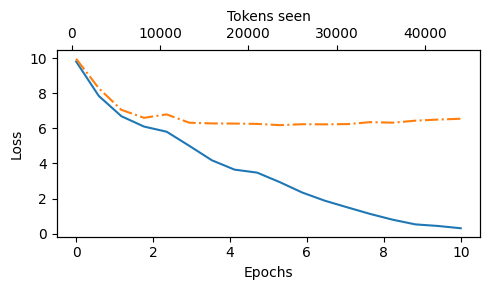

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label='Traning loss')
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens seen')
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [37]:
start_context = 'I HAD always thought Jack Gisburn'
generate_and_print_sample(model, tokenizer, device, start_context)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the


In [38]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
next_token_id = torch.argmax(next_token_logits)
next_token_id

tensor(3)

In [39]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.multinomial(probas, num_samples=1).item()
next_token_id

7

In [40]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f'{freq} x {i}')

print_sampled_tokens(probas)

71 x 0
2 x 1
0 x 2
544 x 3
2 x 4
1 x 5
0 x 6
376 x 7
4 x 8


In [41]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

In [42]:
def print_sampled_tokens_v2(logits):
    torch.manual_seed(123)
    sample = [torch.multinomial(softmax_with_temperature(logits, 2), num_samples=1).item() for i in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f'{freq} x {i}')

print_sampled_tokens_v2(next_token_logits)

158 x 0
20 x 1
12 x 2
391 x 3
37 x 4
5 x 5
4 x 6
340 x 7
33 x 8


In [43]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print('Top logits:', top_logits)
print('Top positions:', top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [44]:
next_token_logits < top_logits[-1]

tensor([False,  True,  True, False,  True,  True,  True, False,  True])

In [45]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [46]:
def generate(model:nn.Module, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:] # 取最后一个词
        if top_k is not None:
            top_logits,_ = torch.topk(logits, top_k)
            logits = torch.where(
                condition=logits < top_logits[:,-1],
                input=torch.tensor(float("-inf")).to(logits.device),
                other=logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [47]:
torch.manual_seed(123)
token_ids = generate(model=model, idx=text_to_token_ids("I HAD always thought Jack Gisburn", tokenizer).to(device), max_new_tokens=15, context_size=GPT_CONFIG_124M['context_length'], top_k=25, temperature=1)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was when


In [48]:
optimizer.load_state_dict

<bound method Optimizer.load_state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.1
)>

In [49]:
for name,param in model.named_parameters():
    print(name, param.numel())

token_emb.weight 38597376
pos_emb.weight 196608
blks.0.norm1.scale 768
blks.0.norm1.shift 768
blks.0.norm2.scale 768
blks.0.norm2.shift 768
blks.0.attn.W_q.weight 589824
blks.0.attn.W_k.weight 589824
blks.0.attn.W_v.weight 589824
blks.0.attn.W_o.weight 589824
blks.0.attn.W_o.bias 768
blks.0.ffn.fc1.weight 2359296
blks.0.ffn.fc1.bias 3072
blks.0.ffn.fc2.weight 2359296
blks.0.ffn.fc2.bias 768
blks.1.norm1.scale 768
blks.1.norm1.shift 768
blks.1.norm2.scale 768
blks.1.norm2.shift 768
blks.1.attn.W_q.weight 589824
blks.1.attn.W_k.weight 589824
blks.1.attn.W_v.weight 589824
blks.1.attn.W_o.weight 589824
blks.1.attn.W_o.bias 768
blks.1.ffn.fc1.weight 2359296
blks.1.ffn.fc1.bias 3072
blks.1.ffn.fc2.weight 2359296
blks.1.ffn.fc2.bias 768
blks.2.norm1.scale 768
blks.2.norm1.shift 768
blks.2.norm2.scale 768
blks.2.norm2.shift 768
blks.2.attn.W_q.weight 589824
blks.2.attn.W_k.weight 589824
blks.2.attn.W_v.weight 589824
blks.2.attn.W_o.weight 589824
blks.2.attn.W_o.bias 768
blks.2.ffn.fc1.weight 2

In [148]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x226d5a9c880>)

In [50]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [52]:
print(settings)
print("Params dict keys:", params.keys())

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params dict keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [53]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [54]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [57]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [59]:
NEW_CONFIG.update({"context_length":1024})
NEW_CONFIG.update({"qkv_bias":True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [61]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [66]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.blks[b].attn.W_q.weight = assign(
            gpt.blks[b].attn.W_q.weight, q_w.T)
        gpt.blks[b].attn.W_k.weight = assign(
            gpt.blks[b].attn.W_k.weight, k_w.T)
        gpt.blks[b].attn.W_v.weight = assign(
            gpt.blks[b].attn.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.blks[b].attn.W_q.bias = assign(
            gpt.blks[b].attn.W_q.bias, q_b)
        gpt.blks[b].attn.W_k.bias = assign(
            gpt.blks[b].attn.W_k.bias, k_b)
        gpt.blks[b].attn.W_v.bias = assign(
            gpt.blks[b].attn.W_v.bias, v_b)

        gpt.blks[b].attn.W_o.weight = assign(
            gpt.blks[b].attn.W_o.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.blks[b].attn.W_o.bias = assign(
            gpt.blks[b].attn.W_o.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.blks[b].ffn.fc1.weight = assign(
            gpt.blks[b].ffn.fc1.weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.blks[b].ffn.fc1.bias = assign(
            gpt.blks[b].ffn.fc1.bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.blks[b].ffn.fc2.weight = assign(
            gpt.blks[b].ffn.fc2.weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.blks[b].ffn.fc2.bias = assign(
            gpt.blks[b].ffn.fc2.bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.blks[b].norm1.scale = assign(
            gpt.blks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.blks[b].norm1.shift = assign(
            gpt.blks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.blks[b].norm2.scale = assign(
            gpt.blks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.blks[b].norm2.shift = assign(
            gpt.blks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享


In [67]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [69]:
torch.manual_seed(123)
token_ids = generate(model=gpt, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25, context_size=NEW_CONFIG["context_length"], top_k=50, temperature=1.5)
print(f'Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


In [71]:
torch.manual_seed(123)
token_ids = generate(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25, context_size=NEW_CONFIG["context_length"], top_k=50, temperature=1.5)
print(f'Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you was "It his Butrow too? I haven't let by his last word.

Well Rick an awful simpleton


In [73]:
train_loss, val_loss = evaluate_mode(model, train_loader, val_loader, device, None)
print(f'train loss:{train_loss}, val loss:{val_loss}')

train loss:0.22818011542161307, val loss:6.589950084686279


In [72]:
# 看下加载了预训练权重后，在训练集和验证集上的loss情况
train_loss, val_loss = evaluate_mode(gpt, train_loader, val_loader, device, None)
print(f'train loss:{train_loss}, val loss:{val_loss}')

train loss:3.753480407926771, val loss:3.5581765174865723


In [74]:
# 对加载了预训练权重的GPT训练1轮看下，相当于全量微调
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(gpt, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=1, eval_iter=5, start_context='Every effort moves you', tokenizer=tokenizer)

Ep 1 (Step 000000)：Train loss 3.872, Val loss 3.740
Ep 1 (Step 000001)：Train loss 3.668, Val loss 3.737
Ep 1 (Step 000002)：Train loss 3.569, Val loss 3.660
Ep 1 (Step 000003)：Train loss 3.394, Val loss 3.584
Ep 1 (Step 000004)：Train loss 3.419, Val loss 3.540
Ep 1 (Step 000005)：Train loss 3.073, Val loss 3.566
Ep 1 (Step 000006)：Train loss 3.014, Val loss 3.546
Ep 1 (Step 000007)：Train loss 2.873, Val loss 3.537
Ep 1 (Step 000008)：Train loss 2.720, Val loss 3.520
Every effort moves you forward, and you are moved by it."I don't know how to say that," he said. "I don't know how to say that. I don't know how to say that. I don't know how to say


In [75]:
# 看下加载了预训练权重后，在训练集和验证集上的loss情况
train_loss, val_loss = evaluate_mode(gpt, train_loader, val_loader, device, None)
print(f'train loss:{train_loss}, val loss:{val_loss}')

train loss:2.807166470421685, val loss:3.519531726837158


In [76]:
torch.manual_seed(123)
token_ids = generate(model=gpt, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25, context_size=NEW_CONFIG["context_length"], top_k=50, temperature=1.5)
print(f'Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you under the weight of his own merits - all else if I managed to manage him like to see. It is impossible to know
